In [4]:
from datasets import *
from iv2_utils import iv2

val1 = load_dataset("friedrichor/ActivityNet_Captions", split = "val1")
val2 = load_dataset("friedrichor/ActivityNet_Captions", split = "val2")
train = load_dataset("friedrichor/ActivityNet_Captions", split = "train")

dataset = concatenate_datasets([val1, val2, train])

In [5]:
dataset

Dataset({
    features: ['video_id', 'video', 'caption', 'source', 'duration', 'timestamps', 'sentences'],
    num_rows: 19811
})

In [6]:
dataset[0]

{'video_id': 'v_uqiMw7tQ1Cc',
 'video': 'v_uqiMw7tQ1Cc.mp4',
 'caption': 'A weight lifting tutorial is given. The coach helps the guy in red with the proper body placement and lifting technique.',
 'source': 'ActivityNet_Captions',
 'duration': 55.15,
 'timestamps': [[0.28, 55.15], [13.79, 54.32]],
 'sentences': ['A weight lifting tutorial is given.',
  'The coach helps the guy in red with the proper body placement and lifting technique.']}

In [7]:
action_dataset = []
total_actions = 0

for item in dataset:
    total_actions += len(item['sentences'])

    for action_label, time_frame in zip(item['sentences'], item['timestamps']):
        action_dataset.append({
            "video": 'video/' + item['video'],
            "caption": action_label.strip(),
            "start_time": round(time_frame[0], 2),
            "end_time": round(time_frame[1], 2),
            "action_duration": round(time_frame[1] - time_frame[0], 2)
        })

action_dataset = Dataset.from_list(action_dataset) \
    .sort('action_duration') \
    .filter(lambda row: row['action_duration'] > 0) \
    .select(range(40000))

print(f"{len(action_dataset):,} total actions in dataset\n")

print("Example action:")
print(action_dataset[-1])

Filter:   0%|          | 0/71957 [00:00<?, ? examples/s]

40,000 total actions in dataset

Example action:
{'video': 'video/v__nvQDglPcmc.mkv', 'caption': 'water polo team is standing by the pool talking to the camera.', 'start_time': 0.0, 'end_time': 27.27, 'action_duration': 27.27}


In [8]:
import random

random.choice(action_dataset)

{'video': 'video/v_rulzKikXMHo.mp4',
 'caption': 'A male picks up the ball.',
 'start_time': 13.08,
 'end_time': 14.32,
 'action_duration': 1.24}

In [9]:
import json

counter = -1

def get_classification_prompt(row):
    global counter
    prompt_dict = {
      "instruction": "Classify the action caption into A, B, or C based on the criteria below. If C, provide a revised caption. Output must be in JSON format.",
      "criteria": {
        "A": "The caption describes a clear 'peak' moment, where the height of the action is happening for only a few frames. 'A person at the height of backflip' counts, but 'A person walks through a park' doesn't count.",
        "B": "The caption is like the park example.",
        "C": "The caption can be adjusted with minimal edits to fit structure A (provide the revised version). You are allowed to tweak the action to fit this, as long as the action is guaranteed to happen in the caption. For example, 'After, a man runs and lands in the sand' could be rewritten as 'The moment when the man lands in the sand'."
      },
      "Examples to Guide You (Please Review Thoroughly To Get An Idea Of How This Works!)": [
        {"input": {"caption": "A guy in a white tee shirt enters a bedroom.", "action_duration": 1.07}, "output": {"classification": "C", "revised_caption": "The moment when a person enters a bedroom."}},
        {"input": {"caption": "She jumps off and lands in the water.", "action_duration": 3.42}, "output": {"classification": "C", "revised_caption": "The moment when the person lands in the water."}},
        {"input": {"caption": "A child eats ice cream.", "action_duration": 2.07}, "output": {"classification": "B"}, "revised_caption": None},
        {"input": {"caption": "The exact moment when a girl shows us her brush.", "action_duration": 5.23}, "output": {"classification": "B", "revised_caption": None}},
        {"input": {"caption": "The exact moment when the dumbbell hits the ground", "action_duration": 1.5}, "output": {"classification": "A", "revised_caption": None}},
        {"input": {"caption": "They do back flips and land in the water.", "action_duration": 1.28}, "output": {"classification": "A", "revised_caption": None}},
        {"input": {"caption": "A rivers roaring rapids are about to carry a large group of rafters.", "action_duration": 2.75}, "output": {"classification": "B", "revised_caption": None}}
      ],
      "input": {
          "caption": row['caption'],
          "duration": row['action_duration']
      }
    }

    prefix = json.dumps(prompt_dict, indent=2)

    suffix = """**Expected Response Format**:
{
  "classification": "B",
  "revised_caption": null
}

**OR**
{
  "classification": "C",
  "revised_caption": "The moment when the person lands in the water."
}
""".strip()

    prompt = prefix + '\n\n' + suffix

    counter += 1
    
    return {"classification_prompt": prompt.strip(), "row_id": counter}

action_dataset_prompts = action_dataset.shuffle(seed=42).map(get_classification_prompt)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [10]:
action_dataset_prompts[5]

{'video': 'video/v_nuEK3POl9jA.mp4',
 'caption': 'He bends down and works his way up with great effort, finally lifting the barbell over his head.',
 'start_time': 8.4,
 'end_time': 28.21,
 'action_duration': 19.81,
 'classification_prompt': '{\n  "instruction": "Classify the action caption into A, B, or C based on the criteria below. If C, provide a revised caption. Output must be in JSON format.",\n  "criteria": {\n    "A": "The caption describes a clear \'peak\' moment, where the height of the action is happening for only a few frames. \'A person at the height of backflip\' counts, but \'A person walks through a park\' doesn\'t count.",\n    "B": "The caption is like the park example.",\n    "C": "The caption can be adjusted with minimal edits to fit structure A (provide the revised version). You are allowed to tweak the action to fit this, as long as the action is guaranteed to happen in the caption. For example, \'After, a man runs and lands in the sand\' could be rewritten as \'T

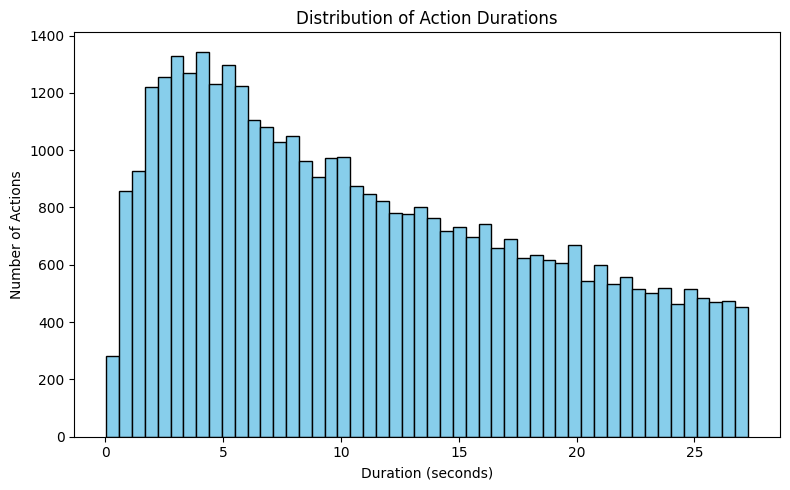

In [11]:
import matplotlib.pyplot as plt

durations = action_dataset['action_duration']

plt.figure(figsize=(8, 5))
plt.hist(durations, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Action Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Actions')
plt.tight_layout()
plt.show()

In [12]:
import json
from datasets import load_dataset, Dataset

OUTPUT_FILE = "anet_batch_requests.jsonl"
FINISHED_FILE = "anet_batch_outputs.jsonl"
MODEL_NAME = "Qwen/Qwen3-14B-AWQ"
TEMPERATURE = 0.6
MAX_TOKENS = 8192

def create_qwen_batch_requests(
    hf_dataset: Dataset,
    output_file_path: str,
    request_id_column: str = "video_id",
    prompt_column: str = "classification_prompt"
):
    request_count = 0

    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for i, row in enumerate(hf_dataset):
            try:
                video_id = row[request_id_column]
                prompt_content = row[prompt_column]

                request = {
                    "custom_id": video_id,
                    "method": "POST",
                    "url": "/v1/chat/completions",
                    "body": {
                        "model": MODEL_NAME,
                        "messages": [
                            {
                                "role": "user",
                                "content": prompt_content
                            }
                        ],
                        "temperature": TEMPERATURE,
                        "max_tokens": MAX_TOKENS
                    }
                }
                json.dump(request, outfile, ensure_ascii=False)
                outfile.write('\n')
                request_count += 1

            except KeyError as e:
                print(f"Skipping row {i} due to missing column: {e}. Row data: {row}")
            except Exception as e:
                print(f"An error occurred processing row {i}: {e}. Row data: {row}")

    print(f"Successfully created {output_file_path} with {request_count} requests.")

create_qwen_batch_requests(
    hf_dataset=action_dataset_prompts,
    output_file_path=OUTPUT_FILE,
    request_id_column="row_id",
    prompt_column="classification_prompt"
)

Successfully created anet_batch_requests.jsonl with 40000 requests.


In [13]:
# Process outputs

import json

video_response_dict = {}
error_summary = {'json_decode_errors': [],'missing_data_errors': [],'unexpected_errors': [],}

line_number = 0

with open(FINISHED_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        line_number += 1
        try:
            data = json.loads(line.strip())
            video_id = data.get("custom_id")
            response_content = data.get("response", {}).get('choices', [{}])[0].get('message', {}).get('content', '').split('</think>')[-1].strip()
            content_part = response_content.split('}')[-1]
            if not content_part.strip().startswith('{'):
                start = response_content.find('{')
                end = response_content.rfind('}') + 1
                if start != -1 and end != 0:
                    content_part = response_content[start:end]
                else:
                    raise ValueError("No JSON object found in response content")
            response = json.loads(content_part)
            if video_id and response:
                video_response_dict[video_id] = response
            else:
                error_summary['missing_data_errors'].append({'line': line_number,'video_id': video_id,'error': 'Missing custom_id or parsed response'})
        except json.JSONDecodeError as e:
            error_summary['json_decode_errors'].append({'line': line_number,'error': str(e),'content': line.strip()})
        except Exception as e:
            error_summary['unexpected_errors'].append({'line': line_number,'error': str(e),'content': line.strip()})

total_processed = line_number
successful_count = len(video_response_dict)
errored_count = sum(len(errors) for errors in error_summary.values())

print("==================")
print("PROCESSING SUMMARY")
print("==================")
print(f"Total lines processed: {total_processed}")
print(f"Successful entries:    {successful_count}")
print(f"Errored entries:       {errored_count}")
print(f"Success rate:          {successful_count/total_processed*100:.1f}%\n")

for error_type, errors in error_summary.items():
    if errors:
        print(f"--- {error_type.replace('_', ' ').title()} ({len(errors)} found) ---")
        for err in errors[:5]:  # Show first 5 examples
            vid = err.get('video_id')
            line_num = err.get('line')
            vid_str = f" (Video ID: {vid})" if vid else ""
            print(f"  Line {line_num}{vid_str}: {err['error'][:100]}...")
        if len(errors) > 5:
            print(f"  ... and {len(errors) - 5} more.")
        print()

if video_response_dict:
    print(f"Sample of successful Video IDs ({min(5, len(video_response_dict))} shown):")
    for video_id in list(video_response_dict.keys())[:5]:
        print(f"  - {video_id}")

PROCESSING SUMMARY
Total lines processed: 40000
Successful entries:    39794
Errored entries:       206
Success rate:          99.5%

--- Json Decode Errors (4 found) ---
  Line 39966: Extra data: line 11 column 1 (char 844)...
  Line 39968: Expecting ',' delimiter: line 4 column 3 (char 95)...
  Line 39989: Extra data: line 12 column 4 (char 395)...
  Line 40000: Extra data: line 6 column 1 (char 56)...

--- Missing Data Errors (1 found) ---
  Line 75: Missing custom_id or parsed response...

--- Unexpected Errors (201 found) ---
  Line 26421: 'NoneType' object has no attribute 'get'...
  Line 26422: 'NoneType' object has no attribute 'get'...
  Line 26423: 'NoneType' object has no attribute 'get'...
  Line 26424: 'NoneType' object has no attribute 'get'...
  Line 26425: 'NoneType' object has no attribute 'get'...
  ... and 196 more.

Sample of successful Video IDs (5 shown):
  - 43
  - 67
  - 70
  - 90
  - 66


In [14]:
for key, json_data in video_response_dict.items():
    if ("revised_caption" not in json_data.keys()) and ("classification" in json_data.keys()):
        video_response_dict[key] |= {"revised_caption": None}

In [15]:
def add_classification_response(row):
    return video_response_dict[row['row_id']]

def is_successful_classification(row):
    return row['row_id'] in video_response_dict.keys()

action_dataset_classified = action_dataset_prompts.filter(is_successful_classification).map(add_classification_response)

action_dataset_classified

Filter:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/39794 [00:00<?, ? examples/s]

Dataset({
    features: ['video', 'caption', 'start_time', 'end_time', 'action_duration', 'classification_prompt', 'row_id', 'classification', 'revised_caption'],
    num_rows: 39794
})

In [34]:
from tabulate import tabulate

# Filter datasets
a_videos = action_dataset_classified.filter(lambda x: x['classification'] == 'A')
b_videos = action_dataset_classified.filter(lambda x: x['classification'] == 'B')
c_videos = action_dataset_classified.filter(lambda x: x['classification'] == 'C')

# Collect info for tabular display
table_data = [
    ["Class A", f"{len(a_videos):,}"],
    ["Class B", f"{len(b_videos):,}"],
    ["Class C", f"{len(c_videos):,}"],
]

print(tabulate(table_data, headers=["Class", "Number of Videos"], tablefmt="fancy_grid"))

Filter:   0%|          | 0/39794 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39794 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39794 [00:00<?, ? examples/s]

╒═════════╤════════════════════╕
│ Class   │ Number of Videos   │
╞═════════╪════════════════════╡
│ Class A │ 142                │
├─────────┼────────────────────┤
│ Class B │ 29,767             │
├─────────┼────────────────────┤
│ Class C │ 9,885              │
╘═════════╧════════════════════╛


Filter:   0%|          | 0/9885 [00:00<?, ? examples/s]

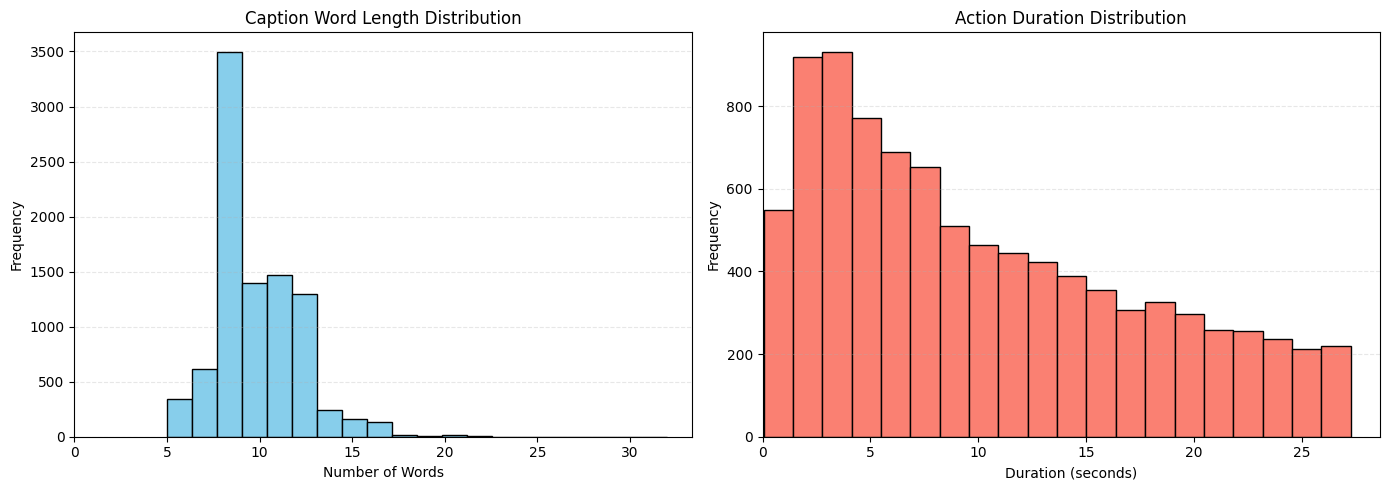

Dataset({
    features: ['video', 'caption', 'start_time', 'end_time', 'action_duration', 'row_id', 'revised_caption'],
    num_rows: 9212
})

In [44]:
def is_high_quality_action(row):
    caption = row['caption']
    no_logo = 'logo' not in caption
    no_text = 'text' not in caption
    no_text = 'camera' not in caption
    
    return no_logo and no_text

flash_dataset = c_videos.filter(is_high_quality_action).remove_columns(['classification', 'classification_prompt'])

caption_lengths = [len(row['revised_caption'].split()) for row in flash_dataset]
durations = [row['action_duration'] for row in flash_dataset]

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Caption Word Lengths ---
ax1.hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Caption Word Length Distribution')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Frequency')
ax1.set_xlim(left=0)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# --- Plot 2: Action Durations ---
ax2.hist(durations, bins=20, color='salmon', edgecolor='black')
ax2.set_title('Action Duration Distribution')
ax2.set_xlabel('Duration (seconds)')
ax2.set_ylabel('Frequency')
ax2.set_xlim(left=0)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Final layout
plt.tight_layout()
plt.show()

flash_dataset

In [45]:
flash_dataset.to_json("flash_dataset_unlabelled.jsonl")

Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

2380333

In [46]:
flash_dataset.push_to_hub('qingy2024/FLASH-Unlabelled')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  59%|#####9    |  543kB /  915kB            

CommitInfo(commit_url='https://huggingface.co/datasets/qingy2024/FLASH-Unlabelled/commit/b97cbc8e5acd5b459ca9632db179e26c2cc8c6a0', commit_message='Upload dataset', commit_description='', oid='b97cbc8e5acd5b459ca9632db179e26c2cc8c6a0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/qingy2024/FLASH-Unlabelled', endpoint='https://huggingface.co', repo_type='dataset', repo_id='qingy2024/FLASH-Unlabelled'), pr_revision=None, pr_num=None)

In [47]:
flash_dataset[0]

{'video': 'video/v_saB1t3Znhk0.mp4',
 'caption': 'The two teens bow after their fight.',
 'start_time': 76.66,
 'end_time': 78.01,
 'action_duration': 1.35,
 'row_id': 2,
 'revised_caption': 'The moment when the two teens bow after their fight.'}